importing for nltk for stopwords removal

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Importing all necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import gensim.downloader as api
import torch
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading csv files of train and test dataset

In [6]:
df_train = pd.read_csv("/content/drive/MyDrive/NLP3/NLP3/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/NLP3/NLP3/test.csv")
print(df_train.shape)
print(df_test.shape)

(2000, 3)
(500, 3)


In [7]:
df_train.head(5)

,index,text,label
0,0,Zimbabwe annual inflation drops to 209 percent...,0
1,1,"More than 1,000 dead in Haiti (09/23/04)-- A m...",0
2,2,Seven die in Japan #39;suicide pact #39; Japa...,0
3,3,Security No. 1 for Afghan head President Hamid...,0
4,4,Palestinians say they hope Bush accepts dealin...,0


In [8]:
df_test.head(5)

,index,text,label
0,0,Detainees seen as minimal threat WASHINGTON --...,0
1,1,Japan's army works out plan to cope with North...,0
2,2,UN council arrives in Nairobi UN Security Coun...,0
3,3,APEC Ministers Urge New Effort on Trade Talks ...,0
4,4,At Least Five Dead in Russia Mine Blast (Reute...,0


Checking whether data is balanced as given in problem statement

In [9]:
df_train['label'].value_counts()

label
0    500
1    500
2    500
3    500
Name: count, dtype: int64

the dataset is balanced

4 labels are given in training dataset. Labels are map with numbers. Mapping of labels with numbers is as follows:
*  World - 0
*  Sports - 1  
*  Business - 2
*  Sci/Tech - 3

In [10]:
df_train['label'].unique()

array([0, 1, 2, 3])

Randomly splitting training data into 10% validation data

In [11]:
df_train, df_valid = train_test_split(df_train, test_size = 0.1, random_state=42)
print(df_train.shape)
print(df_valid.shape)

(1800, 3)
(200, 3)


All the dataframes are concatenated into single dataframe so that it can be use to create the vocabulary for word2vec embeddings.

In [12]:
df_concat = pd.concat([df_train, df_valid, df_test], ignore_index=True)

In [13]:
df_concat.head()

,index,text,label
0,1872,"Rebates Fuel Sales, Frazzle Buyers For retaile...",3
1,526,Rugby-Ireland ring the changes ahead of US tes...,1
2,173,"US, Iraqi forces press raids south of Baghdad ...",0
3,720,Benson shows no fear on -- or off -- the field...,1
4,414,Ships stricken by Algerian storm Rescuers sear...,0


# Data Preprocessing

Function to preprocess the text based on the given conditions. We are doing lowercasing, removing unnecessary symbols, stop words, Replace all \\\ with " ".

In [14]:
def preprocess_text(text):
  text = text.lower()

  text = text.replace('\\',' ')

  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  stop_words = set(stopwords.words('english'))

  tokens = word_tokenize(text)
  words = [w for w in tokens]
  words = [ w for w in words if w is not stop_words]

  text = ' '.join(words)
  return text

In [15]:
df_train['preprocess_text'] = df_train['text'].apply(preprocess_text)
df_valid['preprocess_text'] = df_valid['text'].apply(preprocess_text)
df_test['preprocess_text'] = df_test['text'].apply(preprocess_text)
df_concat['preprocess_text'] = df_concat['text'].apply(preprocess_text)

In [16]:
min_length = min(df_train['text'].str.split().str.len())
max_length = max(df_train['text'].str.split().str.len())
print("Minimum number of words in a sentence:", min_length)
print("Maximum number of words in a sentence:", max_length)

Minimum number of words in a sentence: 11
Maximum number of words in a sentence: 134


In [17]:
from collections import Counter

tokenized_sentence = df_concat['preprocess_text'].apply(lambda x: x.split())
words = [w for sentence in tokenized_sentence for w in sentence ]
word_counts = Counter(words)
print(word_counts)
print(len(word_counts))

Counter({'the': 4336, 'to': 2526, 'a': 2234, 'in': 2045, 'of': 2019, 'and': 1395, 'on': 1184, 'for': 1116, '39s': 690, 'that': 610, 'with': 570, 'as': 557, 'at': 525, 'is': 494, 'new': 479, 'its': 462, 'by': 451, 'said': 429, 'it': 397, 'from': 393, 'us': 389, 'has': 386, 'reuters': 379, 'an': 361, 'ap': 357, 'his': 328, 'after': 322, 'will': 297, 'was': 265, 'have': 246, 'be': 225, 'their': 223, 'up': 219, 'over': 215, 'first': 214, 'two': 199, 'are': 189, 'but': 185, 'this': 183, 'more': 183, 'he': 180, 'world': 171, 'one': 168, 'monday': 162, 'tuesday': 156, 'oil': 152, 'thursday': 151, 'wednesday': 147, 'not': 146, 'out': 146, '39': 142, 'microsoft': 138, 'against': 137, 'last': 137, 'friday': 137, 'inc': 136, 'into': 135, 'who': 135, 'iraq': 133, 'were': 131, 'president': 130, 'about': 129, 'yesterday': 127, 'york': 126, 'no': 125, 'year': 125, 'company': 125, 'been': 123, 'prices': 121, 'million': 119, 'they': 118, 'than': 116, 'had': 116, 'percent': 110, 'security': 109, 'says':

Finding the minimum andf maximum frequent token and their corresponding frequency. There are very large no. of tokens having frequency equal to 1

In [18]:
# Find the minimum frequency token
min_freq_token = min(word_counts, key=word_counts.get)

# Find the maximum frequency token
max_freq_token = max(word_counts, key=word_counts.get)

print(f"Minimum frequency token: '{min_freq_token}', frequency: {word_counts[min_freq_token]}")
print(f"Maximum frequency token: '{max_freq_token}', frequency: {word_counts[max_freq_token]}")

Minimum frequency token: 'frazzle', frequency: 1
Maximum frequency token: 'the', frequency: 4336


In [19]:
tokenized_sentence

0       [rebates, fuel, sales, frazzle, buyers, for, r...
1       [rugbyireland, ring, the, changes, ahead, of, ...
2       [us, iraqi, forces, press, raids, south, of, b...
3       [benson, shows, no, fear, on, or, off, the, fi...
4       [ships, stricken, by, algerian, storm, rescuer...
                              ...                        
2495    [web, still, in, early, days, tech, leaders, s...
2496    [citrix, buying, vpn, company, net6, for, 50, ...
2497    [cheese, sandwich, back, on, ebay, miami, you,...
2498    [make, hotels, just, like, home, hotel, operat...
2499    [cisco, fujitsu, team, on, highend, networking...
Name: preprocess_text, Length: 2500, dtype: object

  Choosing 500 dimension for embeddings, context window for embedding creation is set to 5. min_count is set to 1 as there are many words in the vocabulary having frequency 1 and we dont want to ignore them.
  

In [20]:
model = Word2Vec(tokenized_sentence, vector_size = 200, window = 5, min_count = 1, workers = 4)

In [21]:
print(type(model))

<class 'gensim.models.word2vec.Word2Vec'>


In [22]:
model.build_vocab(tokenized_sentence)

In [23]:
model.train(tokenized_sentence, total_examples= model.corpus_count, epochs=30, report_delay=1)

(2373452, 2839230)

In [24]:
# Get the word embeddings for each token in the vocabulary
vocab = list(model.wv.key_to_index.keys())
word_embeddings = {word: model.wv[word] for word in model.wv.key_to_index}

In [26]:
# len(word_embeddings)
len(vocab)

14313

In [27]:
model.wv['and'].shape

(200,)

Function to generate the embeddings for each words of sentence in a dataset

In [28]:
def generate_embeddings(text):
    cnt = 0
    text = text.split()
    embeddings_of_text = []
    for word in text:
        try:
            embeddings_of_text.append(word_embeddings[word])
        except KeyError:
            # Handle out-of-vocabulary words here
            print(f"Word '{word}' not found in vocabulary, skipping...")
            cnt += 1
    # print(f"count: {cnt}")
    return torch.tensor(embeddings_of_text)

We are first founf out the embeddings for each word of sentence and then found out average embeddings of the sentence by taking average of embeddings of all the tokens in a sentence. This embeddings will be passed to the model.

In [29]:
df_train['text embeddings'] = df_train['preprocess_text'].apply(generate_embeddings)
df_train['average embeddings'] = df_train['text embeddings'].apply(lambda x: torch.mean(x, axis = 0))
df_train['label'] = df_train['label'].apply(lambda x: torch.tensor(x))

<ipython-input-28-3303a5b22b7f>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(embeddings_of_text)


In [30]:
df_valid['text embeddings'] = df_valid['preprocess_text'].apply(generate_embeddings)
df_valid['average embeddings'] = df_valid['text embeddings'].apply(lambda x: torch.mean(x, axis = 0))
df_valid['label'] = df_valid['label'].apply(lambda x: torch.tensor(x))

In [31]:
df_test['text embeddings'] = df_test['preprocess_text'].apply(generate_embeddings)
df_test['average embeddings'] = df_test['text embeddings'].apply(lambda x: torch.mean(x, axis = 0))
df_test['label'] = df_test['label'].apply(lambda x: torch.tensor(x))

In [32]:
# Convert Pandas Series of tensors to list of tensors for training and validation data
X_train = torch.stack([tensor for tensor in df_train['average embeddings']])
y_train = torch.stack([tensor for tensor in df_train['label']])

X_valid = torch.stack([tensor for tensor in df_valid['average embeddings']])
y_valid = torch.stack([tensor for tensor in df_valid['label']])

X_test = torch.stack([tensor for tensor in df_test['average embeddings']])
y_test = torch.stack([tensor for tensor in df_test['label']])

In [33]:
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, layer_size_1, layer_size_2, output_size, dropout_rate):
        super(NeuralNetworkModel, self).__init__()
        self.layer1 = nn.Linear(input_size, layer_size_1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(layer_size_1, layer_size_2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.final_layer = nn.Linear(layer_size_2, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.dropout1(x)
        x = self.activation(self.layer2(x))
        x = self.dropout2(x)
        x = self.final_layer(x)
        return x

Hyperparameters used are :<br>
Learning rate:  0.001<br>
No. of hidden layers = 2<br>
Embedding size = 200<br>
Neurons in hidden layers = 100, 50<br>
No of epochs = 200<br>
Dropout rate = 0.5<br>


In [34]:
input_size = 200
layer_size_1 = 100
layer_size_2 = 50
output_size = 4
total_epochs = 200
dropout_rate = 0.5

model = NeuralNetworkModel(
    input_size = input_size,
    layer_size_1 = layer_size_1,
    layer_size_2 = layer_size_2,
    output_size = output_size,
    dropout_rate = dropout_rate
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# Learning rate scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

best_epoch = -1
best_val_loss = np.inf
best_model_path_W2V =" "

train_losses_W2V = []
val_losses_W2V = []
train_accuracies_W2V = []
val_accuracies_W2V = []

for epoch in range(total_epochs):
  X_train, y_train = X_train.to(device), y_train.to(device)
  outputs = model(X_train)
  train_loss = criterion(outputs, y_train)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model.eval()  # Set model to evaluation mode
  with torch.no_grad():
      X_valid, y_valid = X_valid.to(device), y_valid.to(device)
      val_outputs = model(X_valid)
      val_loss = criterion(val_outputs, y_valid)

  # If current validation loss is better than the previous best, save the model
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_epoch = epoch
      best_model_path_W2V = f"best_model_path_{epoch}.pth"
      torch.save(model.state_dict(), best_model_path_W2V)

  # Compute accuracy
  _, train_predicted = torch.max(outputs, 1)
  train_accuracy = (train_predicted == y_train).sum().item() / len(y_train)

  _, val_predicted = torch.max(val_outputs, 1)
  val_accuracy = (val_predicted == y_valid).sum().item() / len(y_valid)

  # Store metrics for plotting
  train_losses_W2V.append(train_loss.item())
  val_losses_W2V.append(val_loss.item())
  train_accuracies_W2V.append(train_accuracy)
  val_accuracies_W2V.append(val_accuracy)

  print(f'Epoch [{epoch+1}/{total_epochs}], Training Loss: {train_loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')

print("\nTraining finished.")
print(f"Best model is found at epoch: {best_epoch}, best validation loss: {best_val_loss}, best model path: {best_model_path_W2V}")

Epoch [1/200], Training Loss: 1.3910, Training Accuracy: 0.2461, Validation Loss: 1.3846, Validation Accuracy: 0.2300
Epoch [2/200], Training Loss: 1.3830, Training Accuracy: 0.2522, Validation Loss: 1.3773, Validation Accuracy: 0.2300
Epoch [3/200], Training Loss: 1.3752, Training Accuracy: 0.2522, Validation Loss: 1.3701, Validation Accuracy: 0.2350
Epoch [4/200], Training Loss: 1.3677, Training Accuracy: 0.2594, Validation Loss: 1.3626, Validation Accuracy: 0.3400
Epoch [5/200], Training Loss: 1.3600, Training Accuracy: 0.3561, Validation Loss: 1.3548, Validation Accuracy: 0.4900
Epoch [6/200], Training Loss: 1.3521, Training Accuracy: 0.5150, Validation Loss: 1.3467, Validation Accuracy: 0.5750
Epoch [7/200], Training Loss: 1.3438, Training Accuracy: 0.5872, Validation Loss: 1.3383, Validation Accuracy: 0.6150
Epoch [8/200], Training Loss: 1.3351, Training Accuracy: 0.6100, Validation Loss: 1.3294, Validation Accuracy: 0.6450
Epoch [9/200], Training Loss: 1.3257, Training Accuracy:

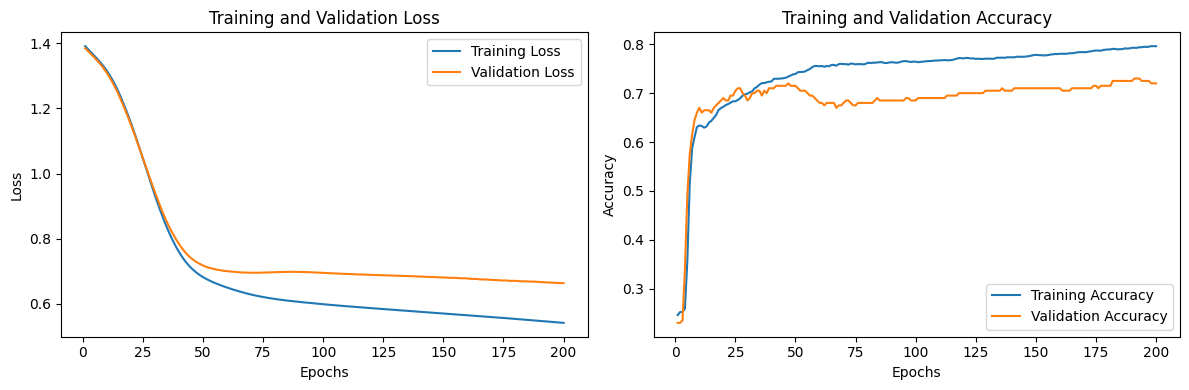

In [35]:
# Plotting
epochs = range(1, total_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_W2V, label='Training Loss')
plt.plot(epochs, val_losses_W2V, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_W2V, label='Training Accuracy')
plt.plot(epochs, val_accuracies_W2V, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
def evaluate(model, X_test, df_test, y_test_W2V, best_model_path_W2V):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model.eval()  # Set model to evaluation mode
    if use_cuda:
        model = model.to(device)
        X_test, y_test_W2V = X_test.to(device), y_test_W2V.to(device)

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test_W2V)

        # Compute accuracy
        _, test_predicted_W2V = torch.max(test_outputs, 1)
        test_accuracy = (test_predicted_W2V == y_test_W2V).sum().item() / len(y_test_W2V)
        print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}')

        return df_test['text'].tolist(), y_test_W2V.cpu().numpy(), test_predicted_W2V.cpu().numpy()

original_sentences, y_test_W2V, test_predicted_W2V = evaluate(model, X_test, df_test, y_test, best_model_path_W2V)

# Create a new dataframe with original sentences, true labels, and predicted labels
results_df_W2V = pd.DataFrame({
    'sentence': original_sentences,
    'true_label': y_test_W2V,
    'predicted_label': test_predicted_W2V
})

Test Loss: 0.5983, Test Accuracy: 0.7720


Test Accuracy: 0.7820
Macro F1 Score: 0.7698
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       125
           1       0.81      0.88      0.85       125
           2       0.78      0.62      0.69       125
           3       0.70      0.82      0.75       125

    accuracy                           0.77       500
   macro avg       0.78      0.77      0.77       500
weighted avg       0.78      0.77      0.77       500



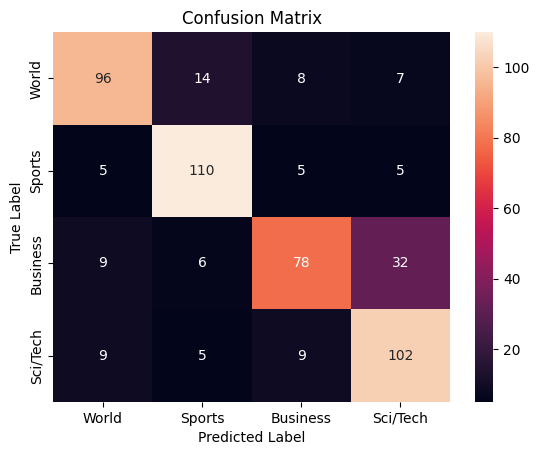

In [37]:
# Calculate macro-f1 score
y_test_W2V = y_test_W2V
test_predicted_W2V = test_predicted_W2V
macro_f1 = f1_score(y_test_W2V, test_predicted_W2V, average='macro')
print("Test Accuracy: 0.7820")
print(f'Macro F1 Score: {macro_f1:.4f}')

# Calculate classification report
report_W2V = classification_report(y_test_W2V, test_predicted_W2V)
print("Classification Report:")
print(report_W2V)
# Plot confusion matrix
cm = confusion_matrix(y_test_W2V, test_predicted_W2V)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [38]:
results_df_W2V.head()

,sentence,true_label,predicted_label
0,Detainees seen as minimal threat WASHINGTON --...,0,0
1,Japan's army works out plan to cope with North...,0,0
2,UN council arrives in Nairobi UN Security Coun...,0,0
3,APEC Ministers Urge New Effort on Trade Talks ...,0,0
4,At Least Five Dead in Russia Mine Blast (Reute...,0,0


In [39]:
results_df_W2V.to_csv("w2v_test.csv")

# Part B (using RNN and LSTM)

In [40]:
df_train.columns

Index(['index', 'text', 'label', 'preprocess_text', 'text embeddings',
       'average embeddings'],
      dtype='object')

In [41]:
word_count_in_sentences = []
for index, row in df_train.iterrows():
  text = row['preprocess_text'].split()
  word_count_in_sentences.append(len(text))

word_count = np.array(word_count_in_sentences)

In [42]:
print(word_count.max())
print(word_count.min())
print(np.mean(word_count))
print(np.median(word_count))

135
11
38.13166666666667
38.0


(array([ 84., 638., 921., 113.,  27.,   8.,   2.,   4.,   0.,   3.]),
 array([ 11. ,  23.4,  35.8,  48.2,  60.6,  73. ,  85.4,  97.8, 110.2,
        122.6, 135. ]),
 <BarContainer object of 10 artists>)

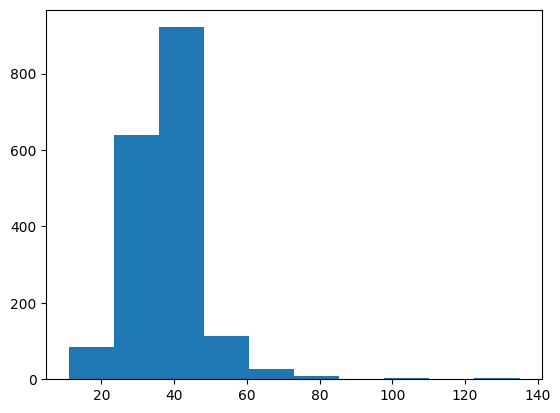

In [43]:
import matplotlib.pyplot as plt
plt.hist(word_count)

In [44]:
word_count_in_sentences_test = []
for index, row in df_test.iterrows():
  text = row['preprocess_text'].split()
  word_count_in_sentences_test.append(len(text))

word_count_test = np.array(word_count_in_sentences_test)

(array([ 26.,  55., 150., 144.,  74.,  33.,   8.,   5.,   4.,   1.]),
 array([16. , 22.4, 28.8, 35.2, 41.6, 48. , 54.4, 60.8, 67.2, 73.6, 80. ]),
 <BarContainer object of 10 artists>)

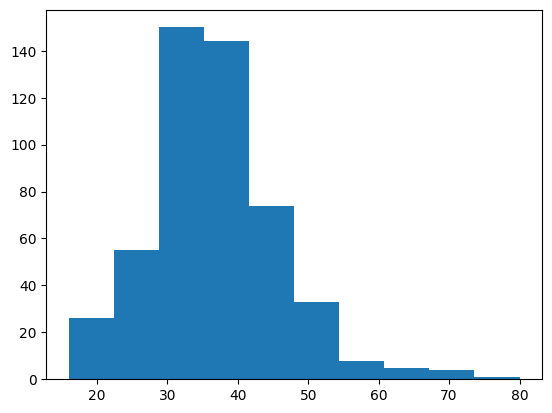

In [45]:
import matplotlib.pyplot as plt
plt.hist(word_count_test)

Vocabulary for RNN will be same as the vocabulary that we have created initally, only change is that there will be 1 extra token 'pad' and we will initialize its embeddings randomly. I havent generated the word embeddings again just because we have added 1 new extra token 'pad'. We will add that token and create the vocabulary mapping

In [48]:
def create_vocab_mapping(data):
    vocab = {}
    index = 0
    # Iterate through all sentences in the dataset
    for sentence in data:
        # Tokenize the sentence into words
        words = sentence.split()
        # Iterate through each word in the sentence
        for word in words:
            # If the word is not already in the vocabulary, add it
            if word not in vocab:
                vocab[word] = index
                index += 1
    vocab['<pad>'] = len(vocab)
    return vocab
# Example usage
data = df_concat['preprocess_text']
vocab_RNN = create_vocab_mapping(data)

# Print the vocabulary
print(vocab_RNN)

{'rebates': 0, 'fuel': 1, 'sales': 2, 'frazzle': 3, 'buyers': 4, 'for': 5, 'retailers': 6, 'and': 7, 'manufacturers': 8, 'are': 9, 'a': 10, 'quick': 11, 'easy': 12, 'way': 13, 'to': 14, 'adjust': 15, 'prices': 16, 'in': 17, 'costconscious': 18, 'marketltbrgtltfont': 19, 'faceverdanams': 20, 'sans': 21, 'serifarialhelvetica': 22, 'size2': 23, 'color666666gtltbgtthe': 24, 'washington': 25, 'postltbgtltfontgt': 26, 'rugbyireland': 27, 'ring': 28, 'the': 29, 'changes': 30, 'ahead': 31, 'of': 32, 'us': 33, 'test': 34, 'ireland': 35, 'coach': 36, 'eddie': 37, 'o': 38, '39sullivan': 39, 'has': 40, 'rested': 41, 'flyhalf': 42, 'ronan': 43, '39gara': 44, 'as': 45, 'he': 46, 'juggles': 47, 'his': 48, 'squad': 49, 'saturday': 50, '39s': 51, 'against': 52, 'united': 53, 'states': 54, 'at': 55, 'lansdowne': 56, 'road': 57, 'iraqi': 58, 'forces': 59, 'press': 60, 'raids': 61, 'south': 62, 'baghdad': 63, 'thousands': 64, 'troops': 65, 'pursued': 66, 'campaign': 67, 'on': 68, 'suspected': 69, 'guerril

In [49]:
MAX_SEQUENCE_LENGTH = 150
pad_token = '<pad>'
unknown_token = '<unk>'
BATCH_SIZE = 32

def pad_or_truncate(text):
    text = text.split()[:MAX_SEQUENCE_LENGTH]
    length = len(text)
    padded_text = text + [pad_token] * (MAX_SEQUENCE_LENGTH - length)
    return ' '.join(padded_text)

df_train['padded_sentence'] = df_train['preprocess_text'].apply(pad_or_truncate)
df_valid['padded_sentence'] = df_valid['preprocess_text'].apply(pad_or_truncate)
df_test['padded_sentence'] = df_test['preprocess_text'].apply(pad_or_truncate)

In [50]:
# Convert labels to tensors
df_train['label'] = df_train['label'].astype(int)
df_train['label'] = df_train['label'].apply(lambda x: torch.tensor(x))

df_valid['label'] = df_valid['label'].astype(int)
df_valid['label'] = df_valid['label'].apply(lambda x: torch.tensor(x))

df_test['label'] = df_test['label'].astype(int)
df_test['label'] = df_test['label'].apply(lambda x: torch.tensor(x))

In [52]:
embedding_dim = 200
random_embedding_pad = np.random.randn(embedding_dim)
# Store the random embedding vector in the word_embeddings dictionary
word_embeddings['<pad>'] = random_embedding_pad

In [53]:
# Convert the dictionary of embeddings to a matrix
vocab_size = len(word_embeddings)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, embedding in word_embeddings.items():
    index = vocab_RNN.get(word)
    if index is not None:
        embedding_matrix[index] = embedding

In [54]:
embedding_matrix.shape

(14314, 200)

In [ ]:
# df_concat['tokenized_index'], embedding_matrix = zip(*df_concat['preprocess_text'].apply(lambda x: tokenize_and_create_embedding_matrix(x, vocab_RNN, word_embeddings, embedding_dim)))

In [56]:
def tokenize_and_index(sentence):
    indexed_sentence = [vocab_RNN[word] for word in sentence.split()]
    return torch.tensor(indexed_sentence)

In [57]:
df_train['input_ids'] = df_train['padded_sentence'].apply(tokenize_and_index)
df_valid['input_ids'] = df_valid['padded_sentence'].apply(tokenize_and_index)
df_test['input_ids'] = df_test['padded_sentence'].apply(tokenize_and_index)

In [58]:
# df_train.head()

,index,text,label,preprocess_text,text embeddings,average embeddings,padded_sentence,input_ids
1872,1872,"Rebates Fuel Sales, Frazzle Buyers For retaile...",tensor(3),rebates fuel sales frazzle buyers for retailer...,"[[tensor(0.4466), tensor(-0.5738), tensor(-0.3...","[tensor(0.4230), tensor(-0.4349), tensor(-0.40...",rebates fuel sales frazzle buyers for retailer...,"[tensor(0), tensor(1), tensor(2), tensor(3), t..."
526,526,Rugby-Ireland ring the changes ahead of US tes...,tensor(1),rugbyireland ring the changes ahead of us test...,"[[tensor(0.3916), tensor(-0.5668), tensor(-0.3...","[tensor(0.3042), tensor(-0.3764), tensor(-0.23...",rugbyireland ring the changes ahead of us test...,"[tensor(27), tensor(28), tensor(29), tensor(30..."
173,173,"US, Iraqi forces press raids south of Baghdad ...",tensor(0),us iraqi forces press raids south of baghdad b...,"[[tensor(-1.1785), tensor(-0.4961), tensor(-0....","[tensor(-0.1816), tensor(-0.5051), tensor(-0.3...",us iraqi forces press raids south of baghdad b...,"[tensor(33), tensor(58), tensor(59), tensor(60..."
720,720,Benson shows no fear on -- or off -- the field...,tensor(1),benson shows no fear on or off the field texas...,"[[tensor(0.2283), tensor(-0.2577), tensor(-0.0...","[tensor(0.5057), tensor(-0.3717), tensor(-0.12...",benson shows no fear on or off the field texas...,"[tensor(79), tensor(80), tensor(81), tensor(82..."
414,414,Ships stricken by Algerian storm Rescuers sear...,tensor(0),ships stricken by algerian storm rescuers sear...,"[[tensor(0.2384), tensor(-0.2186), tensor(-0.1...","[tensor(0.3370), tensor(-0.2228), tensor(-0.26...",ships stricken by algerian storm rescuers sear...,"[tensor(113), tensor(114), tensor(115), tensor..."


In [59]:
class NewsDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __getitem__(self, index):
        # print(f"Index: {index}, Sentences length: {len(self.sentences)}, Labels length: {len(self.labels)}")
        return self.sentences[index], self.labels[index]

    def __len__(self):
        return len(self.sentences)

Dataframe has to reindexed before passing to dataloader because as we have randomly shuffle while splitting into train and valid. So, to avoid index error we have to reindex both train and valid dataframe again.

In [60]:
df_train.reset_index(inplace = True)
df_valid.reset_index(inplace = True)

In [61]:
train_dataset = NewsDataset(df_train['input_ids'], df_train['label'])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

valid_dataset = NewsDataset(df_valid['input_ids'], df_valid['label'])
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

test_dataset = NewsDataset(df_test['input_ids'], df_test['label'])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [62]:
print(df_train['input_ids'][90])
print(df_train['label'][90])

tensor([  169,    17,  1677,  1432,  1174,  1678,    17,  1677,  1679,    51,
          380,  1098,  1414,    68,    76,  1680,  1681,   529,  1679,  1682,
           83,  1683,   529,    17,   242,   803,  1563,  1324,   123,  1684,
         1174,    55,    29,  1685,  1686,  1189,  1687,   811,    78, 14313,
        14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313,
        14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313,
        14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313,
        14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313,
        14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313,
        14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313,
        14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313,
        14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313,
        14313, 14313, 14313, 14313, 14313, 14313, 14313, 14313, 

In [110]:
class BidirectionalRNNClassifier(nn.Module):
    def __init__(self, vocab_size,embedding_matrix, hidden_size, hidden_size2, num_layers, output_size, dropout_rate):
        super(BidirectionalRNNClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)  # Set freeze=False to fine-tune embeddings
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size2)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size2, output_size)


    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        out, _ = self.rnn(embedded)
        # Concatenate the forward and backward hidden states
        out = torch.cat((out[:, :, :self.rnn.hidden_size], out[:, :, self.rnn.hidden_size:]), dim=2)
        # Take the mean across the sequence dimension
        out = torch.mean(out, dim=1)
        out = self.dropout(out)
        out = self.activation(self.fc1(out))
        out = self.fc2(out)
        return out

In [145]:
total_epochs = 30
vocab_size = len(vocab_RNN)
embedding_dim = 200
hidden_size = 100
hidden_size1 = 50
num_layers = 2
output_size = 4
dropout_rate = 0.3

RNN_model = BidirectionalRNNClassifier(vocab_size, embedding_matrix, hidden_size, hidden_size1, num_layers, output_size, dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(RNN_model.parameters(), lr=0.001)
train_losses_RNN = []
valid_losses_RNN = []
train_acc_RNN = []
valid_acc_RNN = []

best_epoch_RNN = -1
best_val_loss_RNN = np.inf
best_model_path_RNN = ""

for epoch in range(total_epochs):
    RNN_model.train()
    train_loss, correct_train, total_train = 0, 0, 0
    val_loss, correct_val, total_val = 0, 0, 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = RNN_model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / total_train
    train_accuracy = correct_train / total_train
    train_losses_RNN.append(avg_train_loss)
    train_acc_RNN.append(train_accuracy)

    # Validation
    RNN_model.eval()
    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = RNN_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_accuracy = correct_val / total_val
    # If current validation loss is better than the previous best, save the model
    if avg_val_loss < best_val_loss_RNN:
        best_val_loss_RNN = avg_val_loss
        best_epoch_RNN = epoch
        best_model_path_RNN = f"best_model_path_RNN_{epoch}.pth"
        torch.save(RNN_model.state_dict(), best_model_path_RNN)

    valid_losses_RNN.append(avg_val_loss)
    valid_acc_RNN.append(val_accuracy)

    # Print statistics
    print(f"Epoch [{epoch+1}/{total_epochs}], "
          f"Train Loss: {avg_train_loss:.8f}, Train Accuracy: {train_accuracy:.8f}, "
          f"Val Loss: {avg_val_loss:.8f}, Val Accuracy: {val_accuracy:.8f}")

print("Training Done.")

Epoch [1/30], Train Loss: 1.26285021, Train Accuracy: 0.37277778, Val Loss: 1.16885524, Val Accuracy: 0.37000000
Epoch [2/30], Train Loss: 0.99976669, Train Accuracy: 0.46111111, Val Loss: 1.00972775, Val Accuracy: 0.46000000
Epoch [3/30], Train Loss: 0.85921248, Train Accuracy: 0.56000000, Val Loss: 0.87800742, Val Accuracy: 0.66500000
Epoch [4/30], Train Loss: 0.70581337, Train Accuracy: 0.68222222, Val Loss: 0.81090186, Val Accuracy: 0.74000000
Epoch [5/30], Train Loss: 0.48588794, Train Accuracy: 0.81444444, Val Loss: 0.68831727, Val Accuracy: 0.76500000
Epoch [6/30], Train Loss: 0.43059687, Train Accuracy: 0.84888889, Val Loss: 0.78403750, Val Accuracy: 0.70500000
Epoch [7/30], Train Loss: 0.35566411, Train Accuracy: 0.86444444, Val Loss: 0.69468037, Val Accuracy: 0.76000000
Epoch [8/30], Train Loss: 0.20535938, Train Accuracy: 0.93111111, Val Loss: 0.56965378, Val Accuracy: 0.81000000
Epoch [9/30], Train Loss: 0.22081197, Train Accuracy: 0.92222222, Val Loss: 0.63016910, Val Accu

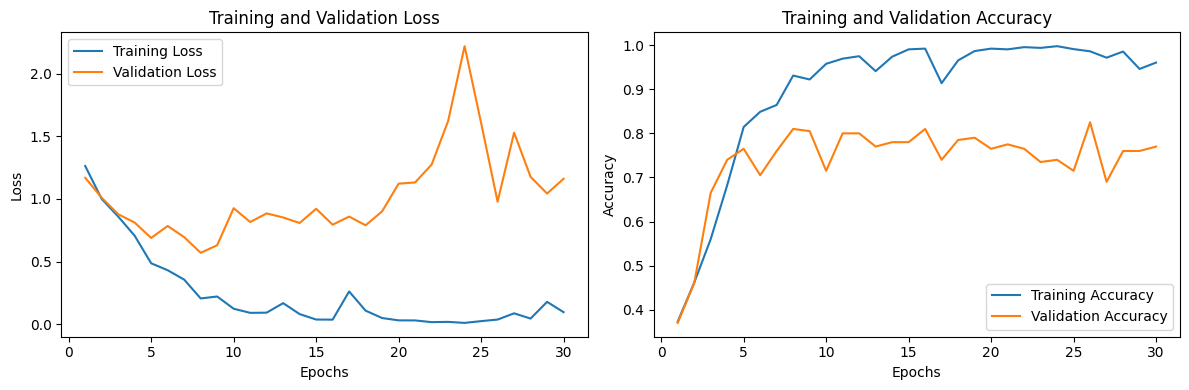

In [148]:
# Plotting
epochs = range(1, total_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_RNN, label='Training Loss')
plt.plot(epochs, valid_losses_RNN, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_RNN, label='Training Accuracy')

plt.plot(epochs, valid_acc_RNN, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [149]:
def evaluate_RNN(RNN_model, test_dataloader, df_test, best_model_path_RNN):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        RNN_model = RNN_model.cuda()

    y_test_RNN = []
    test_predicted_RNN = []
    original_sentences = []

    RNN_model.load_state_dict(torch.load(best_model_path_RNN))
    RNN_model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for i, test_input in enumerate(test_dataloader):
            inputs, labels = test_input
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = RNN_model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Save true and predicted labels
            y_test_RNN.extend(labels.cpu().numpy())
            test_predicted_RNN.extend(predicted.cpu().numpy())

             # Append original sentences
            batch_sentences = df_test.iloc[i * test_dataloader.batch_size : (i + 1) * test_dataloader.batch_size]['text'].tolist()
            original_sentences.extend(batch_sentences)

    test_accuracy_RNN = sum(true == pred for true, pred in zip(y_test_RNN, test_predicted_RNN)) / len(y_test_RNN)
    print(f'Test Accuracy: {test_accuracy_RNN:.3f}')

    return original_sentences, y_test_RNN, test_predicted_RNN, test_accuracy_RNN

original_sentences, y_test_RNN, test_predicted_RNN, test_accuracy_RNN = evaluate_RNN(RNN_model, test_dataloader, df_test, best_model_path_RNN)

# Create a new dataframe with original sentences, true labels, and predicted labels
results_df_RNN = pd.DataFrame({
    'text': original_sentences,
    'label': y_test_RNN,
    'preds': test_predicted_RNN
})

Test Accuracy: 0.790


Test Accuracy: 0.79
Macro F1 Score: 0.7899
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       125
           1       0.91      0.92      0.92       125
           2       0.69      0.69      0.69       125
           3       0.74      0.75      0.75       125

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500



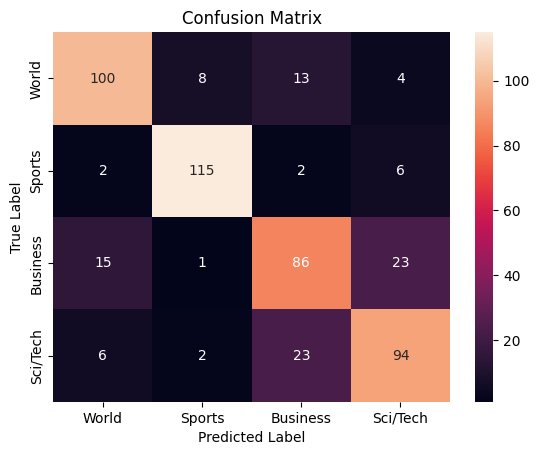

In [150]:
# Calculate macro-f1 score
macro_f1 = f1_score(y_test_RNN, test_predicted_RNN, average='macro')
print(f"Test Accuracy: {test_accuracy_RNN}")
print(f'Macro F1 Score: {macro_f1:.4f}')
# Calculate classification report
report_RNN = classification_report(y_test_RNN, test_predicted_RNN)
print("Classification Report:")
print(report_RNN)

# Plot confusion matrix
cm = confusion_matrix(y_test_RNN, test_predicted_RNN)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [151]:
results_df_RNN.head()

,text,label,preds
0,Detainees seen as minimal threat WASHINGTON --...,0,0
1,Japan's army works out plan to cope with North...,2,0
2,UN council arrives in Nairobi UN Security Coun...,2,2
3,APEC Ministers Urge New Effort on Trade Talks ...,2,2
4,At Least Five Dead in Russia Mine Blast (Reute...,1,1


In [152]:
results_df_RNN.to_csv("rnn_test.csv")

## Bi-LSTM

In [157]:
class BidirectionalLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size,hidden_size1, num_layers, output_size, dropout_rate):
        super(BidirectionalLSTMClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)  # Set freeze=False to fine-tune embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size1)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, output_size)


    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        out, _ = self.lstm(embedded)
        # Concatenate the forward and backward hidden states
        out = torch.cat((out[:, :, :self.lstm.hidden_size], out[:, :, self.lstm.hidden_size:]), dim=2)
        # Take the mean across the sequence dimension
        out = torch.mean(out, dim=1)
        out = self.dropout(out)
        out = self.activation(self.fc1(out))
        out = self.fc2(out)
        return out

In [212]:
total_epochs = 15
vocab_size = len(vocab_RNN)
embedding_dim = 200
hidden_size = 100
hidden_size1 = 50
num_layers = 1
output_size = 4
dropout_rate = 0.4

LSTM_model = BidirectionalLSTMClassifier(vocab_size, embedding_dim, hidden_size,hidden_size1, num_layers, output_size, dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.001)
train_losses_LSTM = []
valid_losses_LSTM = []
train_acc_LSTM = []
valid_acc_LSTM = []

best_epoch_LSTM = -1
best_val_loss_LSTM = np.inf
best_model_path_LSTM = ""

for epoch in range(total_epochs):
    LSTM_model.train()
    train_loss, correct_train, total_train = 0, 0, 0
    val_loss, correct_val, total_val = 0, 0, 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = LSTM_model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / total_train
    train_accuracy = correct_train / total_train
    train_losses_LSTM.append(avg_train_loss)
    train_acc_LSTM.append(train_accuracy)

    LSTM_model.eval()
    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = LSTM_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_accuracy = correct_val / total_val
    if avg_val_loss < best_val_loss_LSTM:
        best_val_loss_LSTM = avg_val_loss
        # print(f"best val loss: {best_val_loss_LSTM}")
        best_epoch_LSTM = epoch
        best_model_path_LSTM = f"best_model_path_LSTM_{epoch}.pth"
        torch.save(LSTM_model.state_dict(), best_model_path_LSTM)

    valid_losses_LSTM.append(avg_val_loss)
    valid_acc_LSTM.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{total_epochs}], "
          f"Train Loss: {avg_train_loss:.8f}, Train Accuracy: {train_accuracy:.8f}, "
          f"Val Loss: {avg_val_loss:.8f}, Val Accuracy: {val_accuracy:.8f}")

print("Training Done.")

Epoch [1/15], Train Loss: 1.22915019, Train Accuracy: 0.42555556, Val Loss: 0.93714598, Val Accuracy: 0.61500000
Epoch [2/15], Train Loss: 0.78111282, Train Accuracy: 0.70611111, Val Loss: 0.70523042, Val Accuracy: 0.71500000
Epoch [3/15], Train Loss: 0.55201589, Train Accuracy: 0.81000000, Val Loss: 0.59067848, Val Accuracy: 0.79500000
Epoch [4/15], Train Loss: 0.39178787, Train Accuracy: 0.86166667, Val Loss: 0.65731011, Val Accuracy: 0.76000000
Epoch [5/15], Train Loss: 0.28632774, Train Accuracy: 0.90944444, Val Loss: 0.61457224, Val Accuracy: 0.80000000
Epoch [6/15], Train Loss: 0.15760269, Train Accuracy: 0.95500000, Val Loss: 0.57227967, Val Accuracy: 0.83000000
Epoch [7/15], Train Loss: 0.08194228, Train Accuracy: 0.98111111, Val Loss: 0.62681491, Val Accuracy: 0.84000000
Epoch [8/15], Train Loss: 0.05288300, Train Accuracy: 0.98833333, Val Loss: 0.82187699, Val Accuracy: 0.77000000
Epoch [9/15], Train Loss: 0.03739331, Train Accuracy: 0.99111111, Val Loss: 0.78460581, Val Accu

In [213]:
print(f"Best model is found at epoch: {best_epoch_LSTM}, best validation loss: {best_val_loss_LSTM}, best model path: {best_model_path_LSTM}")

Best model is found at epoch: 5, best validation loss: 0.5722796714305878, best model path: best_model_path_LSTM_5.pth


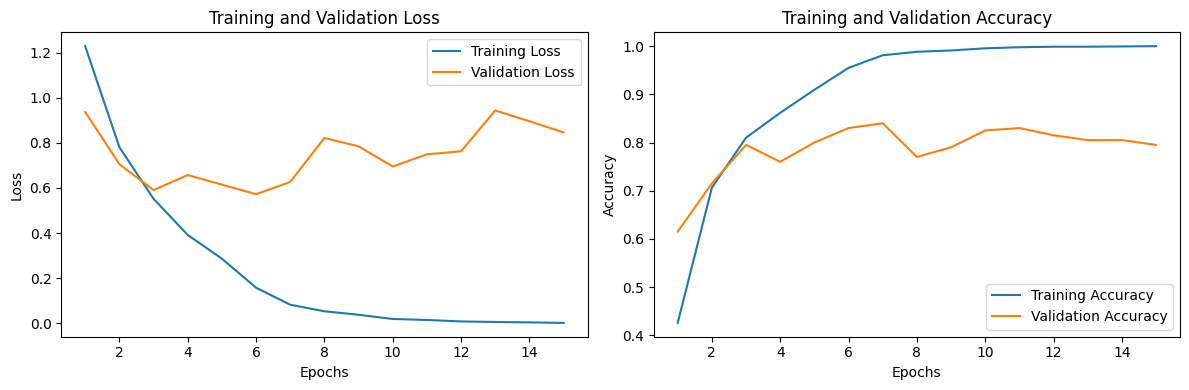

In [214]:
# Plotting
epochs = range(1, total_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_LSTM, label='Training Loss')
plt.plot(epochs, valid_losses_LSTM, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_LSTM, label='Training Accuracy')
plt.plot(epochs, valid_acc_LSTM, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [215]:
def evaluate_LSTM(LSTM_model, test_dataloader, df_test, best_model_path_LSTM):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        LSTM_model = LSTM_model.cuda()

    y_test_LSTM = []
    test_predicted_LSTM = []
    original_sentences = []

    LSTM_model.load_state_dict(torch.load(best_model_path_LSTM))
    LSTM_model.eval()  # Set LSTM_model to evaluation mode

    with torch.no_grad():
        for i, test_input in enumerate(test_dataloader):
            inputs, labels = test_input
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = LSTM_model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Save true and predicted labels
            y_test_LSTM.extend(labels.cpu().numpy())
            test_predicted_LSTM.extend(predicted.cpu().numpy())

             # Append original sentences
            batch_sentences = df_test.iloc[i * test_dataloader.batch_size : (i + 1) * test_dataloader.batch_size]['text'].tolist()
            original_sentences.extend(batch_sentences)

    test_accuracy_LSTM = sum(true == pred for true, pred in zip(y_test_LSTM, test_predicted_LSTM)) / len(y_test_LSTM)
    print(f'Test Accuracy: {test_accuracy_LSTM:.3f}')

    return original_sentences, y_test_LSTM, test_predicted_LSTM, test_accuracy_LSTM

original_sentences, y_test_LSTM, test_predicted_LSTM, test_accuracy_LSTM = evaluate_LSTM(LSTM_model,test_dataloader, df_test, best_model_path_LSTM)

# Create a new dataframe with original sentences, true labels, and predicted labels
results_df_LSTM = pd.DataFrame({
    'text': original_sentences,
    'label': y_test_LSTM,
    'preds': test_predicted_LSTM
})

Test Accuracy: 0.808


test accuracy: 0.808
Macro F1 Score: 0.8066
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       125
           1       0.90      0.90      0.90       125
           2       0.76      0.66      0.70       125
           3       0.74      0.86      0.80       125

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



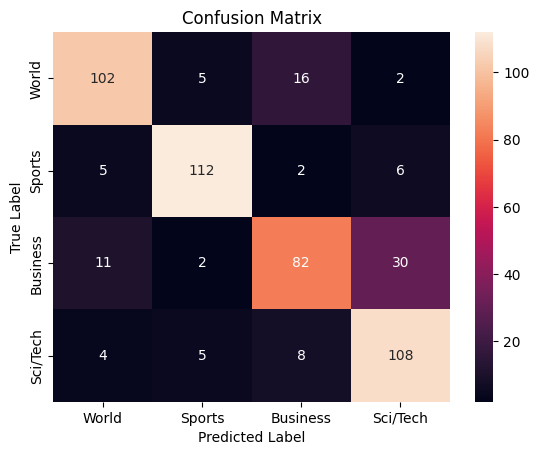

In [217]:
# Calculate macro-f1 score
macro_f1 = f1_score(y_test_LSTM, test_predicted_LSTM, average='macro')
print(f"test accuracy: {test_accuracy_LSTM}")
print(f'Macro F1 Score: {macro_f1:.4f}')

# Calculate classification report
report_LSTM = classification_report(y_test_LSTM, test_predicted_LSTM)
print("Classification Report:")
print(report_LSTM)

# Plot confusion matrix
cm = confusion_matrix(y_test_LSTM, test_predicted_LSTM)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [211]:
results_df_LSTM.head()

,text,label,preds
0,Detainees seen as minimal threat WASHINGTON --...,3,0
1,Japan's army works out plan to cope with North...,0,0
2,UN council arrives in Nairobi UN Security Coun...,2,2
3,APEC Ministers Urge New Effort on Trade Talks ...,3,2
4,At Least Five Dead in Russia Mine Blast (Reute...,3,3


In [ ]:
results_df_LSTM.to_csv("lstm_test.csv")